# Labeled Faces in the Wild 

## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import *  
from data_downloaders import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 50
batch_size = 8
lr = 0.001
k = 3


## Load Labeled Faces in the Wild 
### http://vis-www.cs.umass.edu/lfw/

LFW already downloaded.


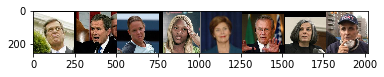

In [3]:
get_lfw()

data_dir = "../../Datasets/lfw/lfw_15/"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
k = 0 
for i in img_paths: 
    name = i.split('/')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        k += 1


img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.8 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class LFWDataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        image = io.imread(img_path)
        label = self.people_to_idx[img_path.split('/')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

trainset = LFWDataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = LFWDataset(lfw_test_list, people_to_idx, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## Train Model 

In [4]:
net = models.tiny_cnn(n_in=3, n_out=200, n_hidden=32, size=250).to(device)

net.apply(models.weights_init)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [5]:
train(net, trainloader, testloader, optimizer, loss, n_epochs, verbose=True)

[0/50][0/360] loss = 5.497265
[0/50][1/360] loss = 171.415939
[0/50][2/360] loss = 238.942871
[0/50][3/360] loss = 285.232025
[0/50][4/360] loss = 303.477325
[0/50][5/360] loss = 266.474274
[0/50][6/360] loss = 147.354767
[0/50][7/360] loss = 188.384613
[0/50][8/360] loss = 182.737518
[0/50][9/360] loss = 140.291351
[0/50][10/360] loss = 133.535400
[0/50][11/360] loss = 210.982285
[0/50][12/360] loss = 166.437500
[0/50][13/360] loss = 139.154785
[0/50][14/360] loss = 138.421936
[0/50][15/360] loss = 142.297028
[0/50][16/360] loss = 155.127609
[0/50][17/360] loss = 155.336746
[0/50][18/360] loss = 144.198975
[0/50][19/360] loss = 161.500427
[0/50][20/360] loss = 109.702072
[0/50][21/360] loss = 122.185814
[0/50][22/360] loss = 92.980942
[0/50][23/360] loss = 64.553329
[0/50][24/360] loss = 120.478127
[0/50][25/360] loss = 105.244781
[0/50][26/360] loss = 67.241882
[0/50][27/360] loss = 78.247467
[0/50][28/360] loss = 66.363197
[0/50][29/360] loss = 137.797363
[0/50][30/360] loss = 112.6

[0/50][251/360] loss = 31.353132
[0/50][252/360] loss = 48.794441
[0/50][253/360] loss = 38.842987
[0/50][254/360] loss = 40.696964
[0/50][255/360] loss = 16.961967
[0/50][256/360] loss = 27.998928
[0/50][257/360] loss = 47.441891
[0/50][258/360] loss = 29.350170
[0/50][259/360] loss = 48.355759
[0/50][260/360] loss = 34.285969
[0/50][261/360] loss = 42.171185
[0/50][262/360] loss = 38.709740
[0/50][263/360] loss = 26.566105
[0/50][264/360] loss = 29.283190
[0/50][265/360] loss = 49.397861
[0/50][266/360] loss = 21.544176
[0/50][267/360] loss = 31.212547
[0/50][268/360] loss = 28.881058
[0/50][269/360] loss = 28.765348
[0/50][270/360] loss = 23.538967
[0/50][271/360] loss = 52.934898
[0/50][272/360] loss = 19.483887
[0/50][273/360] loss = 25.395668
[0/50][274/360] loss = 37.970543
[0/50][275/360] loss = 22.990143
[0/50][276/360] loss = 24.412739
[0/50][277/360] loss = 34.868927
[0/50][278/360] loss = 19.725950
[0/50][279/360] loss = 33.983391
[0/50][280/360] loss = 24.734009
[0/50][281

[1/50][144/360] loss = 6.863935
[1/50][145/360] loss = 5.599064
[1/50][146/360] loss = 3.567321
[1/50][147/360] loss = 9.975427
[1/50][148/360] loss = 11.301918
[1/50][149/360] loss = 6.233764
[1/50][150/360] loss = 6.839138
[1/50][151/360] loss = 8.703701
[1/50][152/360] loss = 7.077730
[1/50][153/360] loss = 4.664567
[1/50][154/360] loss = 7.840706
[1/50][155/360] loss = 4.854347
[1/50][156/360] loss = 4.304893
[1/50][157/360] loss = 5.494431
[1/50][158/360] loss = 11.132360
[1/50][159/360] loss = 7.125765
[1/50][160/360] loss = 5.255553
[1/50][161/360] loss = 3.681112
[1/50][162/360] loss = 9.087101
[1/50][163/360] loss = 6.718989
[1/50][164/360] loss = 7.937922
[1/50][165/360] loss = 5.390171
[1/50][166/360] loss = 5.964321
[1/50][167/360] loss = 8.218036
[1/50][168/360] loss = 10.195008
[1/50][169/360] loss = 2.991255
[1/50][170/360] loss = 3.601029
[1/50][171/360] loss = 6.409518
[1/50][172/360] loss = 6.640571
[1/50][173/360] loss = 4.298761
[1/50][174/360] loss = 15.755299
[1/5

[2/50][45/360] loss = 2.825990
[2/50][46/360] loss = 2.582623
[2/50][47/360] loss = 1.966597
[2/50][48/360] loss = 1.032281
[2/50][49/360] loss = 0.319354
[2/50][50/360] loss = 1.591828
[2/50][51/360] loss = 1.845652
[2/50][52/360] loss = 0.604628
[2/50][53/360] loss = 0.579397
[2/50][54/360] loss = 0.556181
[2/50][55/360] loss = 4.109146
[2/50][56/360] loss = 3.342291
[2/50][57/360] loss = 1.328292
[2/50][58/360] loss = 1.735707
[2/50][59/360] loss = 1.335094
[2/50][60/360] loss = 1.233529
[2/50][61/360] loss = 2.105661
[2/50][62/360] loss = 1.153862
[2/50][63/360] loss = 0.767139
[2/50][64/360] loss = 0.893315
[2/50][65/360] loss = 0.778627
[2/50][66/360] loss = 0.982345
[2/50][67/360] loss = 1.374480
[2/50][68/360] loss = 1.331363
[2/50][69/360] loss = 2.626591
[2/50][70/360] loss = 1.824002
[2/50][71/360] loss = 2.024951
[2/50][72/360] loss = 1.378440
[2/50][73/360] loss = 4.282189
[2/50][74/360] loss = 1.637648
[2/50][75/360] loss = 1.299189
[2/50][76/360] loss = 2.433804
[2/50][7

[2/50][308/360] loss = 1.408273
[2/50][309/360] loss = 2.138113
[2/50][310/360] loss = 1.340763
[2/50][311/360] loss = 0.929694
[2/50][312/360] loss = 3.634914
[2/50][313/360] loss = 1.766941
[2/50][314/360] loss = 1.784527
[2/50][315/360] loss = 0.496182
[2/50][316/360] loss = 0.912810
[2/50][317/360] loss = 2.094325
[2/50][318/360] loss = 0.951723
[2/50][319/360] loss = 1.867373
[2/50][320/360] loss = 0.440986
[2/50][321/360] loss = 1.208154
[2/50][322/360] loss = 0.802660
[2/50][323/360] loss = 1.493554
[2/50][324/360] loss = 2.530306
[2/50][325/360] loss = 1.922694
[2/50][326/360] loss = 1.883080
[2/50][327/360] loss = 0.316625
[2/50][328/360] loss = 1.802438
[2/50][329/360] loss = 0.718230
[2/50][330/360] loss = 3.975020
[2/50][331/360] loss = 0.134153
[2/50][332/360] loss = 1.407396
[2/50][333/360] loss = 0.988716
[2/50][334/360] loss = 2.019017
[2/50][335/360] loss = 1.023835
[2/50][336/360] loss = 1.928792
[2/50][337/360] loss = 2.273714
[2/50][338/360] loss = 2.526867
[2/50][3

[3/50][211/360] loss = 0.752094
[3/50][212/360] loss = 0.677611
[3/50][213/360] loss = 0.586897
[3/50][214/360] loss = 0.531767
[3/50][215/360] loss = 0.053473
[3/50][216/360] loss = 0.920719
[3/50][217/360] loss = 0.235628
[3/50][218/360] loss = 0.070197
[3/50][219/360] loss = 0.091361
[3/50][220/360] loss = 0.077343
[3/50][221/360] loss = 0.050223
[3/50][222/360] loss = 0.313665
[3/50][223/360] loss = 0.225961
[3/50][224/360] loss = 0.876788
[3/50][225/360] loss = 0.069139
[3/50][226/360] loss = 0.424098
[3/50][227/360] loss = 0.543891
[3/50][228/360] loss = 0.355152
[3/50][229/360] loss = 0.983143
[3/50][230/360] loss = 0.022552
[3/50][231/360] loss = 0.377192
[3/50][232/360] loss = 0.941783
[3/50][233/360] loss = 0.579801
[3/50][234/360] loss = 1.293952
[3/50][235/360] loss = 1.754263
[3/50][236/360] loss = 0.080777
[3/50][237/360] loss = 1.542254
[3/50][238/360] loss = 0.016345
[3/50][239/360] loss = 1.160911
[3/50][240/360] loss = 0.040700
[3/50][241/360] loss = 0.876100
[3/50][2

[4/50][117/360] loss = 0.493685
[4/50][118/360] loss = 0.423749
[4/50][119/360] loss = 0.365787
[4/50][120/360] loss = 0.602040
[4/50][121/360] loss = 0.237078
[4/50][122/360] loss = 1.028830
[4/50][123/360] loss = 0.959352
[4/50][124/360] loss = 1.184853
[4/50][125/360] loss = 0.018931
[4/50][126/360] loss = 1.397648
[4/50][127/360] loss = 0.038762
[4/50][128/360] loss = 0.041626
[4/50][129/360] loss = 0.530506
[4/50][130/360] loss = 0.139956
[4/50][131/360] loss = 0.182732
[4/50][132/360] loss = 0.510399
[4/50][133/360] loss = 0.747099
[4/50][134/360] loss = 0.084260
[4/50][135/360] loss = 0.100742
[4/50][136/360] loss = 0.765842
[4/50][137/360] loss = 0.333319
[4/50][138/360] loss = 0.249495
[4/50][139/360] loss = 0.972143
[4/50][140/360] loss = 0.127458
[4/50][141/360] loss = 0.243791
[4/50][142/360] loss = 0.561390
[4/50][143/360] loss = 0.018638
[4/50][144/360] loss = 0.358187
[4/50][145/360] loss = 0.169985
[4/50][146/360] loss = 0.004329
[4/50][147/360] loss = 0.014739
[4/50][1

[5/50][17/360] loss = 0.582958
[5/50][18/360] loss = 0.045959
[5/50][19/360] loss = 0.427506
[5/50][20/360] loss = 0.014637
[5/50][21/360] loss = 0.084985
[5/50][22/360] loss = 0.088492
[5/50][23/360] loss = 0.123389
[5/50][24/360] loss = 0.036784
[5/50][25/360] loss = 0.042020
[5/50][26/360] loss = 0.414814
[5/50][27/360] loss = 0.058766
[5/50][28/360] loss = 0.212223
[5/50][29/360] loss = 0.024217
[5/50][30/360] loss = 0.185387
[5/50][31/360] loss = 0.464095
[5/50][32/360] loss = 0.124631
[5/50][33/360] loss = 0.274547
[5/50][34/360] loss = 0.004290
[5/50][35/360] loss = 0.051964
[5/50][36/360] loss = 0.079534
[5/50][37/360] loss = 0.008254
[5/50][38/360] loss = 0.802847
[5/50][39/360] loss = 0.035512
[5/50][40/360] loss = 0.298469
[5/50][41/360] loss = 0.055352
[5/50][42/360] loss = 0.053534
[5/50][43/360] loss = 0.079976
[5/50][44/360] loss = 0.003303
[5/50][45/360] loss = 0.043376
[5/50][46/360] loss = 0.051120
[5/50][47/360] loss = 0.505152
[5/50][48/360] loss = 0.123123
[5/50][4

[5/50][278/360] loss = 0.058712
[5/50][279/360] loss = 0.016903
[5/50][280/360] loss = 0.001373
[5/50][281/360] loss = 0.138684
[5/50][282/360] loss = 1.152672
[5/50][283/360] loss = 0.002305
[5/50][284/360] loss = 0.005375
[5/50][285/360] loss = 0.037407
[5/50][286/360] loss = 0.801380
[5/50][287/360] loss = 0.220548
[5/50][288/360] loss = 0.511563
[5/50][289/360] loss = 0.001786
[5/50][290/360] loss = 0.048924
[5/50][291/360] loss = 0.019572
[5/50][292/360] loss = 0.125836
[5/50][293/360] loss = 0.022357
[5/50][294/360] loss = 0.019590
[5/50][295/360] loss = 0.572098
[5/50][296/360] loss = 0.072377
[5/50][297/360] loss = 0.038074
[5/50][298/360] loss = 0.082913
[5/50][299/360] loss = 0.003916
[5/50][300/360] loss = 0.107969
[5/50][301/360] loss = 0.085591
[5/50][302/360] loss = 0.579151
[5/50][303/360] loss = 0.214870
[5/50][304/360] loss = 0.063785
[5/50][305/360] loss = 0.016891
[5/50][306/360] loss = 0.067544
[5/50][307/360] loss = 0.026651
[5/50][308/360] loss = 0.004848
[5/50][3

[6/50][183/360] loss = 0.012761
[6/50][184/360] loss = 0.616941
[6/50][185/360] loss = 0.454598
[6/50][186/360] loss = 0.010191
[6/50][187/360] loss = 0.021632
[6/50][188/360] loss = 0.233967
[6/50][189/360] loss = 0.313700
[6/50][190/360] loss = 0.352710
[6/50][191/360] loss = 0.052863
[6/50][192/360] loss = 0.492682
[6/50][193/360] loss = 0.002632
[6/50][194/360] loss = 0.558605
[6/50][195/360] loss = 0.003857
[6/50][196/360] loss = 0.569137
[6/50][197/360] loss = 1.920359
[6/50][198/360] loss = 0.051172
[6/50][199/360] loss = 0.346459
[6/50][200/360] loss = 0.155347
[6/50][201/360] loss = 0.086689
[6/50][202/360] loss = 0.520844
[6/50][203/360] loss = 0.139280
[6/50][204/360] loss = 0.487058
[6/50][205/360] loss = 0.224497
[6/50][206/360] loss = 0.000103
[6/50][207/360] loss = 0.140738
[6/50][208/360] loss = 0.434416
[6/50][209/360] loss = 0.316378
[6/50][210/360] loss = 0.023931
[6/50][211/360] loss = 0.012406
[6/50][212/360] loss = 0.018032
[6/50][213/360] loss = 0.030961
[6/50][2

[7/50][81/360] loss = 0.292735
[7/50][82/360] loss = 0.005274
[7/50][83/360] loss = 0.439299
[7/50][84/360] loss = 0.012975
[7/50][85/360] loss = 0.552720
[7/50][86/360] loss = 0.002612
[7/50][87/360] loss = 0.649331
[7/50][88/360] loss = 0.136061
[7/50][89/360] loss = 1.568302
[7/50][90/360] loss = 0.085612
[7/50][91/360] loss = 0.557063
[7/50][92/360] loss = 0.399126
[7/50][93/360] loss = 0.084254
[7/50][94/360] loss = 0.008005
[7/50][95/360] loss = 0.190156
[7/50][96/360] loss = 0.011771
[7/50][97/360] loss = 0.074803
[7/50][98/360] loss = 0.294893
[7/50][99/360] loss = 0.072971
[7/50][100/360] loss = 0.093510
[7/50][101/360] loss = 0.156410
[7/50][102/360] loss = 0.047155
[7/50][103/360] loss = 0.004760
[7/50][104/360] loss = 0.005689
[7/50][105/360] loss = 0.017095
[7/50][106/360] loss = 0.734364
[7/50][107/360] loss = 0.245991
[7/50][108/360] loss = 0.124916
[7/50][109/360] loss = 0.033360
[7/50][110/360] loss = 0.333632
[7/50][111/360] loss = 0.075925
[7/50][112/360] loss = 0.70

[7/50][341/360] loss = 0.095721
[7/50][342/360] loss = 0.472651
[7/50][343/360] loss = 0.023773
[7/50][344/360] loss = 1.478891
[7/50][345/360] loss = 0.055667
[7/50][346/360] loss = 0.740884
[7/50][347/360] loss = 0.046202
[7/50][348/360] loss = 0.053646
[7/50][349/360] loss = 0.316638
[7/50][350/360] loss = 0.120691
[7/50][351/360] loss = 0.002641
[7/50][352/360] loss = 1.311542
[7/50][353/360] loss = 0.088456
[7/50][354/360] loss = 0.053167
[7/50][355/360] loss = 0.644510
[7/50][356/360] loss = 0.951931
[7/50][357/360] loss = 0.263081
[7/50][358/360] loss = 0.024806
[7/50][359/360] loss = 0.051251
[7/50]

Total accuracy = 31.43 %


[8/50][0/360] loss = 0.858494
[8/50][1/360] loss = 0.039612
[8/50][2/360] loss = 0.033002
[8/50][3/360] loss = 0.017428
[8/50][4/360] loss = 0.133494
[8/50][5/360] loss = 1.390716
[8/50][6/360] loss = 0.103960
[8/50][7/360] loss = 0.006399
[8/50][8/360] loss = 0.028014
[8/50][9/360] loss = 0.005444
[8/50][10/360] loss = 0.010655
[8/50][11/360] loss = 3.27

[8/50][240/360] loss = 0.472140
[8/50][241/360] loss = 0.074346
[8/50][242/360] loss = 0.222044
[8/50][243/360] loss = 0.256936
[8/50][244/360] loss = 0.705243
[8/50][245/360] loss = 0.190432
[8/50][246/360] loss = 0.008664
[8/50][247/360] loss = 0.175763
[8/50][248/360] loss = 0.030236
[8/50][249/360] loss = 0.044898
[8/50][250/360] loss = 0.412146
[8/50][251/360] loss = 0.368233
[8/50][252/360] loss = 0.023438
[8/50][253/360] loss = 0.075753
[8/50][254/360] loss = 0.045307
[8/50][255/360] loss = 0.426049
[8/50][256/360] loss = 0.220935
[8/50][257/360] loss = 0.361302
[8/50][258/360] loss = 0.011900
[8/50][259/360] loss = 0.778073
[8/50][260/360] loss = 0.758667
[8/50][261/360] loss = 1.324971
[8/50][262/360] loss = 0.074469
[8/50][263/360] loss = 0.053697
[8/50][264/360] loss = 0.233909
[8/50][265/360] loss = 0.035619
[8/50][266/360] loss = 0.133416
[8/50][267/360] loss = 0.052542
[8/50][268/360] loss = 0.230837
[8/50][269/360] loss = 0.360623
[8/50][270/360] loss = 0.314176
[8/50][2

[9/50][147/360] loss = 0.071435
[9/50][148/360] loss = 0.001681
[9/50][149/360] loss = 0.004428
[9/50][150/360] loss = 0.004733
[9/50][151/360] loss = 0.004552
[9/50][152/360] loss = 0.000233
[9/50][153/360] loss = 0.000942
[9/50][154/360] loss = 0.009244
[9/50][155/360] loss = 0.012276
[9/50][156/360] loss = 0.002377
[9/50][157/360] loss = 0.000194
[9/50][158/360] loss = 0.001815
[9/50][159/360] loss = 0.008254
[9/50][160/360] loss = 0.100805
[9/50][161/360] loss = 0.014427
[9/50][162/360] loss = 0.087178
[9/50][163/360] loss = 0.111621
[9/50][164/360] loss = 0.044619
[9/50][165/360] loss = 0.103452
[9/50][166/360] loss = 0.010865
[9/50][167/360] loss = 0.001110
[9/50][168/360] loss = 0.033189
[9/50][169/360] loss = 0.232558
[9/50][170/360] loss = 0.002873
[9/50][171/360] loss = 0.003437
[9/50][172/360] loss = 0.005948
[9/50][173/360] loss = 0.133226
[9/50][174/360] loss = 0.033600
[9/50][175/360] loss = 0.001817
[9/50][176/360] loss = 0.042123
[9/50][177/360] loss = 0.033689
[9/50][1

[10/50][49/360] loss = 0.099698
[10/50][50/360] loss = 0.005234
[10/50][51/360] loss = 0.056676
[10/50][52/360] loss = 0.001835
[10/50][53/360] loss = 0.586656
[10/50][54/360] loss = 0.192652
[10/50][55/360] loss = 0.000513
[10/50][56/360] loss = 0.013322
[10/50][57/360] loss = 0.004305
[10/50][58/360] loss = 0.498381
[10/50][59/360] loss = 0.174656
[10/50][60/360] loss = 0.028900
[10/50][61/360] loss = 0.019712
[10/50][62/360] loss = 0.001507
[10/50][63/360] loss = 0.031750
[10/50][64/360] loss = 0.068511
[10/50][65/360] loss = 0.019458
[10/50][66/360] loss = 0.849919
[10/50][67/360] loss = 0.000395
[10/50][68/360] loss = 0.233885
[10/50][69/360] loss = 0.205180
[10/50][70/360] loss = 0.657904
[10/50][71/360] loss = 0.432029
[10/50][72/360] loss = 0.236698
[10/50][73/360] loss = 0.053238
[10/50][74/360] loss = 0.004907
[10/50][75/360] loss = 0.157988
[10/50][76/360] loss = 0.022514
[10/50][77/360] loss = 0.265895
[10/50][78/360] loss = 1.681550
[10/50][79/360] loss = 0.140309
[10/50][

[10/50][301/360] loss = 0.840091
[10/50][302/360] loss = 0.001790
[10/50][303/360] loss = 0.236629
[10/50][304/360] loss = 0.000033
[10/50][305/360] loss = 0.248063
[10/50][306/360] loss = 0.025719
[10/50][307/360] loss = 0.006594
[10/50][308/360] loss = 0.003024
[10/50][309/360] loss = 0.007764
[10/50][310/360] loss = 0.146695
[10/50][311/360] loss = 0.485845
[10/50][312/360] loss = 0.117791
[10/50][313/360] loss = 0.379003
[10/50][314/360] loss = 0.080477
[10/50][315/360] loss = 0.084642
[10/50][316/360] loss = 0.173627
[10/50][317/360] loss = 0.361828
[10/50][318/360] loss = 0.000502
[10/50][319/360] loss = 0.070014
[10/50][320/360] loss = 0.000095
[10/50][321/360] loss = 0.007650
[10/50][322/360] loss = 0.084042
[10/50][323/360] loss = 0.007422
[10/50][324/360] loss = 0.004373
[10/50][325/360] loss = 0.065720
[10/50][326/360] loss = 0.444075
[10/50][327/360] loss = 0.056953
[10/50][328/360] loss = 0.027406
[10/50][329/360] loss = 0.458017
[10/50][330/360] loss = 0.043097
[10/50][33

Process Process-46:
Process Process-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
   

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c02462513475>", line 1, in <module>
    train(net, trainloader, testloader, optimizer, loss, n_epochs, verbose=True)
  File "../src_code/train.py", line 37, in train
    eval_target_net(net, test_loader, classes=classes)
  File "../src_code/metrics.py", line 19, in eval_target_net
    for i, (imgs, lbls) in enumerate(testloader):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/multiprocessing/connection.p

KeyboardInterrupt: 